In [32]:
import numpy as np
import random

BEST_REWARD = 12
MID_REWARD = 0

class RelOvergenEnv:

    def __init__(self, state_dim):
        self.obs_dim = 2
        self.act_dim = 2

        self.state_dim = state_dim
        self.unit = 10.0 / state_dim
        self.states = list(np.arange(0.0, 10.0, self.unit))

        self.agents_pos = [0, 0]

        self.optimal_state = [
            int(state_dim / 4) * self.unit, 
            int(state_dim / 5) * self.unit]
        self.suboptimal_state = [
            10.0 - int(state_dim / 4) * self.unit, 
            10.0 - int(state_dim / 5) * self.unit]
        
        self.max_steps = state_dim
        self.current_step = 0

    def reset(self):
        for a_i in range(2):
            self.agents_pos[a_i] = random.randint(0, self.state_dim - 1)
        self.current_step = 0
        return [self.agents_pos, self.agents_pos]

    def compute_reward(self):
        opti = BEST_REWARD - 25 * (
            (self.states[self.agents_pos[0]] - self.optimal_state[0]) ** 2 + 
            (self.states[self.agents_pos[1]] - self.optimal_state[1]) ** 2)
        subopti = MID_REWARD - 0.125 * (
            (self.states[self.agents_pos[0]] - self.suboptimal_state[0]) ** 2 + 
            (self.states[self.agents_pos[1]] - self.suboptimal_state[1]) ** 2)
        return max(opti, subopti)

    def step(self, actions):
        for a_i in range(2):
            self.agents_pos[a_i] += actions[a_i][0]
            self.agents_pos[a_i] -= actions[a_i][1]
            if self.agents_pos[a_i] < 0:
                self.agents_pos[a_i] = 0
            elif self.agents_pos[a_i] >= self.state_dim:
                self.agents_pos[a_i] = self.state_dim - 1
        next_states = [self.agents_pos, self.agents_pos]

        reward = self.compute_reward()
        rewards =[reward, reward]
        
        self.current_step += 1
        done = float(self.current_step >= self.max_steps)
        dones = [done, done]
        
        return next_states, rewards, dones, None
    
    def close(self):
        pass

In [44]:
env = RelOvergenEnv(1000)

[2.5, 2.0]
[7.5, 8.0]


In [45]:
def get_reward_function(env):
    reward = np.zeros((env.state_dim, env.state_dim))
    for i in range(env.state_dim):
        for j in range(env.state_dim):
            env.agents_pos = [i, j]
            reward[i, j] = env.compute_reward()
    return reward

<AxesSubplot:>

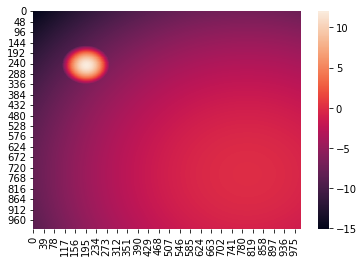

In [46]:
import seaborn as sns

reward = get_reward_function(env)
sns.heatmap(reward)

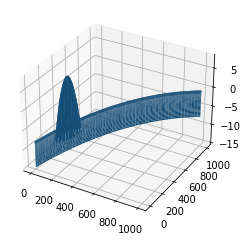

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot_surface(list(range(1000)), list(range(1000)), reward)